In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 17 21:10:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import torchvision.models as models
from torchvision import datasets, transforms
from torchsummary import summary
from torchvision.models import mobilenet_v2
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

from __future__ import print_function
from __future__ import division

import time
import os
import copy


import io
import os
from PIL import Image
import time
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121


In [6]:
!pip install split-folders

In [7]:
import splitfolders

In [8]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU')
else:
    print('CUDA is available!  Training on GPU')

CUDA is available!  Training on GPU


In [9]:
#directory
data_dir = '/content/drive/MyDrive/dataset'

In [10]:
splitfolders.ratio(data_dir, output="output", seed=1337, ratio=(.8, 0.2))

Copying files: 2967 files [00:13, 212.46 files/s]


In [11]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
train_dir = 'output/train'
test_dir = 'output/val'

Train = datasets.ImageFolder(train_dir,data_transforms)
Test = datasets.ImageFolder(test_dir,test_transforms)

trainloader = torch.utils.data.DataLoader(Train, batch_size=4,
                                             shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(Test, batch_size=4,
                                             shuffle=True, num_workers=4)

In [35]:
#for images, labels in trainloader:
    #print(labels)

In [13]:
class_names = Train.classes
print(class_names)

[' angular', 'anthracnose', 'blossomblight', 'graymold', 'leafspot', 'powderyleaf', 'powderymildew', 'ripe', 'unripe']


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [16]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [17]:
for image, label in Train:
    image_tensor = image.unsqueeze(0)  # Add batch dimension

    #print("Min:", image_tensor.min(), "Max:", image_tensor.max())
    features = feature_extractor(images=image_tensor, return_tensors='pt')
    #print(features)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [39]:
import torch

def collate_fn(batch):
    # Unpack the batch of tuples into separate lists for images and labels
    images, labels = zip(*batch)

    # Stack images into a single tensor
    image_tensor = torch.stack(images)

    # Convert labels to a tensor
    label_tensor = torch.tensor(labels)

    # Return a dictionary containing image tensors and label tensor
    return {
        'pixel_values': image_tensor,
        'labels': label_tensor
    }


In [19]:
!pip install datasets

In [41]:
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [42]:
from transformers import ViTForImageClassification

labels = class_names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
!pip install transformers
!pip install accelerate

In [23]:
!pip show accelerate

Name: accelerate
Version: 0.28.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [43]:
from accelerate import Accelerator

In [47]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  save_steps=1000,
  eval_steps=1000,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [48]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=Train,
    eval_dataset=Test,
    tokenizer=feature_extractor,
)

In [49]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
1000,0.000500,0.114580,0.983221
2000,0.000200,0.124802,0.983221


***** train metrics *****
  epoch                    =         30.0
  total_flos               = 5133776960GF
  train_loss               =       0.0074
  train_runtime            =   0:07:54.49
  train_samples_per_second =      149.905
  train_steps_per_second   =        4.742


In [51]:
metrics = trainer.evaluate(eval_dataset=testloader.dataset)

# Log and save evaluation metrics
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       30.0
  eval_accuracy           =     0.9832
  eval_loss               =     0.1146
  eval_runtime            = 0:00:03.72
  eval_samples_per_second =    160.017
  eval_steps_per_second   =     20.136


In [53]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'dataset',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)


Precision: 0.9837957775855838
Recall: 0.9832214765100671
F1 Score: 0.9831667912254705
Accuracy: 0.9832214765100671


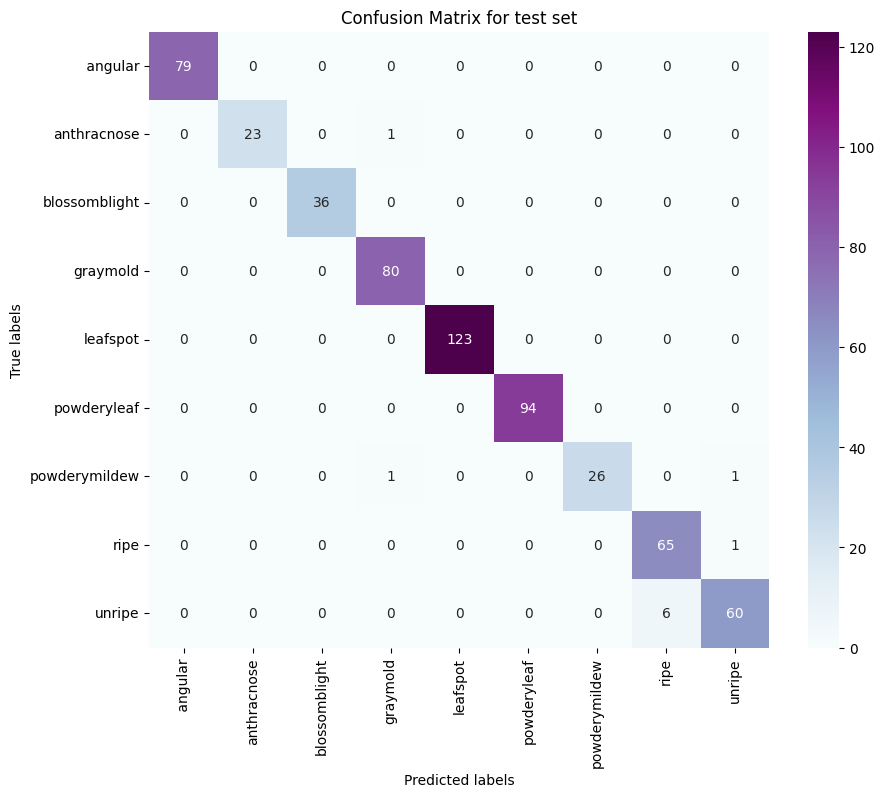

In [60]:
import seaborn as sns


model.eval()


all_preds = []
all_targets = []


for data, target in testloader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()


    output = model(data)
    probabilities = torch.softmax(output.logits, dim=1)
    _, pred = torch.max(probabilities, 1)

    all_preds.extend(pred.cpu().numpy())
    all_targets.extend(target.cpu().numpy())


cm = confusion_matrix(all_targets, all_preds)


precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
accuracy = accuracy_score(all_targets, all_preds)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g',cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for test set')
plt.show()
